In [289]:
##Clases basicas
import numpy as np
import sys

class Node:
    # Clase nodo
    def __call__(self,x):
        return self.forward(x)

    def __str__(self):
        return str(self.out)

class PreActivation(Node):
    # Pre-activación wx+b
    def __init__(self, input_size, output_size):
        self.w = np.random.uniform(0,1,input_size)
        self.b = np.random.uniform(0,1)

    def forward(self, x):
        self.input = x
        self.out = np.dot(self.input,self.w) + self.b
        return self

    def backward(self, consumer_grad=1):
        self.grad = np.dot(consumer_grad, self.w.T)
        self.grad_w = np.dot(self.input.T ,consumer_grad)
        self.grad_b = np.sum(consumer_grad,axis=0)
        return self  
            

class Sigmoid(Node):
    def __init__(self, node):
        self.preactivacion = node
    def forward(self,x):
        self.input = x
        self.sigmoid = 1 / (1+np.exp(-self.preactivacion.forward(x).out))
        self.out = np.where(0.5 > self.sigmoid, 0, 1)
        return self
    def backward(self, consumer_grad=1):
        self.sigmoid_der = self.sigmoid * (1 - self.sigmoid)
        self.grad = consumer_grad * self.sigmoid_der
        return self.preactivacion.backward(consumer_grad=self.grad)
        


class BinaryCrossEntropy(Node):
    # Error de clasificación binario
    def __init__(self, node):
        self.activación = node
    def forward(self,x,y):
        epsilon = sys.float_info.epsilon
        self.pred, self.y = x, y
        if(y == 0):
            self.out = -np.log(1-x.sigmoid+epsilon)
        else:
            self.out = -np.log(x.sigmoid-epsilon)
        return 

    def backward(self):
        if self.y == 1:
            self.grad = -1/self.y
        else:
            self.grad = 1/1-self.y
        return self.activación.backward(consumer_grad=self.grad) 


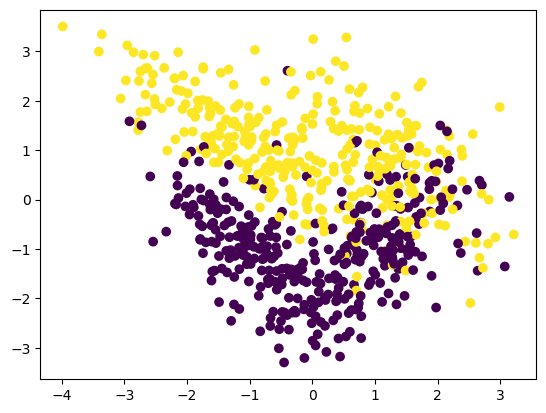

In [290]:
#Separacion de datos
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0
)

x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.3)

plt.scatter(x_train[:,0], x_train[:,1], c=y_train)
plt.show()

In [291]:
print(x_train.shape)

(700, 2)


In [292]:
##Linear regresion

from tqdm import tqdm

pre = PreActivation(2,1)
sig = Sigmoid(pre)
criterion = BinaryCrossEntropy(sig)

epochs = 100
lr = 0.1
for t in tqdm(range(epochs)):
    for x_i, y_i in zip(x_train, y_train):
        pred = sig.forward(x_i)
        criterion.forward(pred,y_i)
        a = criterion.backward()
        pre.w -= a.grad_w *lr
        pre.b -= a.grad_b *lr


100%|██████████| 100/100 [00:01<00:00, 52.29it/s]


In [293]:
#Evaluacion
from sklearn.metrics import classification_report

y_pred = [sig.forward(x_i).out for x_i in x_eval]
print(classification_report(y_pred, y_eval))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86       123
           1       0.95      0.82      0.88       177

    accuracy                           0.87       300
   macro avg       0.87      0.88      0.87       300
weighted avg       0.88      0.87      0.87       300



In [294]:
print(pre.w, pre.b)

[ 4.04224357 13.39795439] 2.3676253041050117


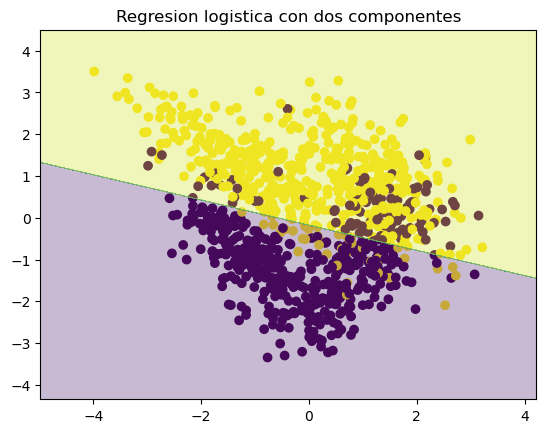

In [295]:
plt.scatter(x[:, 0], x[:, 1], c=y)

plt.title("Regresion logistica con dos componentes")

x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), 
                     np.linspace(y_min, y_max, 1000))

Z = [sig.forward(x_i).out for x_i in np.c_[xx.ravel(), yy.ravel()]]
Z = np.array(Z)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)

plt.show()

In [296]:
##Perceptron
class Perceptron(Node):
    def __init__(self, node):
        self.preactivacion = node
    def forward(self, x):
        self.input = x
        self.wsum = self.preactivacion.forward(x).out
        if (self.wsum>=0):
            self.out = 1
        else:
            self.out = 0
        return self
perc = Perceptron(pre)
y_pred = [perc.forward(x_i).out for x_i in x_eval]
print(classification_report(y_pred, y_eval))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86       123
           1       0.95      0.82      0.88       177

    accuracy                           0.87       300
   macro avg       0.87      0.88      0.87       300
weighted avg       0.88      0.87      0.87       300



In [297]:
##Regresion lineal

class SquareError(Node):
    def __init__(self, node):
        self.activacion =  node
    
    def forward(self,x,y):
        self.pred, self.y = x,y;
        self.out = ((self.pred.out - self.y)**2)/2
        return
    def backward(self):
        self.grad = self.pred.out - self.y
        return self.activacion.backward(consumer_grad=self.grad)




In [298]:

x, y = make_regression(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    noise= 0.3
)
x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.3)


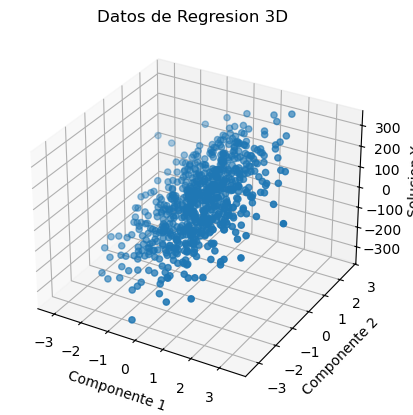

In [299]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_train[:, 0], x_train[:, 1], y_train)

ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Solucion Y")
plt.title("Datos de Regresion 3D ")

plt.show()

In [300]:
linreg = PreActivation(2,1)
criterion = SquareError(linreg)

epochs = 100
lr = 0.1
for t in tqdm(range(epochs)):
    for x_i, y_i in zip(x_train, y_train):
        pred = linreg.forward(x_i)
        criterion.forward(pred,y_i)
        a = criterion.backward()
        linreg.w -= a.grad_w *lr
        linreg.b -= a.grad_b *lr

100%|██████████| 100/100 [00:01<00:00, 80.84it/s]


In [301]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = [linreg.forward(x_i).out for x_i in x_eval]

In [302]:
print(linreg.w,linreg.b)

[51.78328168 95.4222914 ] 0.03084435207877853


In [303]:
print(f'MSE: {mean_squared_error(y_pred, y_eval)}')
print(f'R2E: {r2_score(y_pred, y_eval)}')

MSE: 0.10482219480839657
R2E: 0.9999908870286874


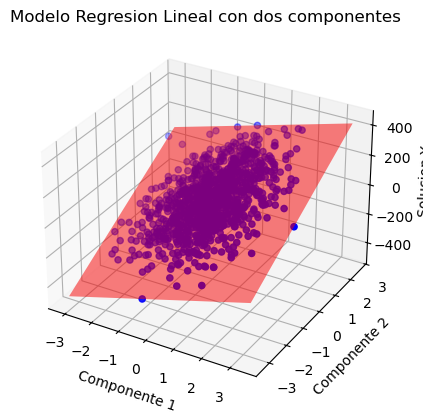

In [304]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x[:, 0], x[:, 1], y, color='blue', label='Data points')

x1 = np.linspace(x[:, 0].min(), x[:, 0].max(), 10)
x2 = np.linspace(x[:, 1].min(), x[:, 1].max(), 10)
x1, x2 = np.meshgrid(x1, x2)
y_pred_plane = linreg.w[0] * x1 + linreg.w[1] * x2 + linreg.b

ax.plot_surface(x1, x2, y_pred_plane, color='red', alpha=0.5, rstride=100, cstride=100)

# Labels
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Solucion Y")
plt.title("Modelo Regresion Lineal con dos componentes")

plt.show()